## Example of online analysis using OnACID

Complete pipeline for online processing using CaImAn Online (OnACID).
The demo demonstrates the analysis of a sequence of files using the CaImAn online
algorithm. The steps include i) motion correction, ii) tracking current 
components, iii) detecting new components, iv) updating of spatial footprints.
The script demonstrates how to construct and use the params and online_cnmf
objects required for the analysis, and presents the various parameters that
can be passed as options. A plot of the processing time for the various steps
of the algorithm is also included.
@author: Eftychios Pnevmatikakis @epnev
Special thanks to Andreas Tolias and his lab at Baylor College of Medicine
for sharing the data used in this demo.

In [1]:
from IPython import get_ipython
import logging
import matplotlib.pyplot as plt
import numpy as np

import caiman as cm
from caiman.source_extraction import cnmf
from caiman.utils.utils import download_demo

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.INFO)

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

import bokeh.plotting as bpl
bpl.output_notebook()

2024-07-31 10:54:48.937984: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 10:54:49.321293: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading BokehJS ...

## First download the data

The function ```download_demo``` will look for the datasets ```Tolias_mesoscope_*.hdf5``` ins your caiman_data folder inside the subfolder specified by the variable ```fld_name``` and will download the files if they do not exist.

In [2]:
fld_name = 'Mesoscope'                              # folder inside ./example_movies where files will be saved
fnames = []
fnames.append(download_demo('Tolias_mesoscope_1.hdf5',fld_name))
fnames.append(download_demo('Tolias_mesoscope_2.hdf5',fld_name))
fnames.append(download_demo('Tolias_mesoscope_3.hdf5',fld_name))

print(fnames)                                          # your list of files should look something like this

   151966228 [utils.py:       download_demo():96] [553680] downloading Tolias_mesoscope_1.hdf5 with urllib
   151966229 [utils.py:       download_demo():97] [553680] GET https://caiman.flatironinstitute.org/~neuro/caiman_downloadables/Tolias_mesoscope_1.hdf5 HTTP/1.1
   151966840 [utils.py:       download_demo():96] [553680] downloading Tolias_mesoscope_2.hdf5 with urllib
   151966841 [utils.py:       download_demo():97] [553680] GET https://caiman.flatironinstitute.org/~neuro/caiman_downloadables/Tolias_mesoscope_2.hdf5 HTTP/1.1
   151967367 [utils.py:       download_demo():96] [553680] downloading Tolias_mesoscope_3.hdf5 with urllib
   151967369 [utils.py:       download_demo():97] [553680] GET https://caiman.flatironinstitute.org/~neuro/caiman_downloadables/Tolias_mesoscope_3.hdf5 HTTP/1.1


['/mnt/home/mpaez/caiman_data/example_movies/Mesoscope/Tolias_mesoscope_1.hdf5', '/mnt/home/mpaez/caiman_data/example_movies/Mesoscope/Tolias_mesoscope_2.hdf5', '/mnt/home/mpaez/caiman_data/example_movies/Mesoscope/Tolias_mesoscope_3.hdf5']


## Set up some parameters

Here we set up some parameters for running OnACID. We use the same `params` object as in batch processing with CNMF.

In [3]:
fr = 15                                                             # frame rate (Hz)
decay_time = 0.5                                                    # approximate length of transient event in seconds
gSig = (4,4)                                                        # expected half size of neurons
p = 1                                                               # order of AR indicator dynamics
min_SNR = 1                                                         # minimum SNR for accepting new components
rval_thr = 0.90                                                     # correlation threshold for new component inclusion
ds_factor = 1                                                       # spatial downsampling factor (increases speed but may lose some fine structure)
gnb = 2                                                             # number of background components
gSig = tuple(np.ceil(np.array(gSig)/ds_factor).astype('int'))       # recompute gSig if downsampling is involved
mot_corr = True                                                     # flag for online motion correction 
pw_rigid = False                                                    # flag for pw-rigid motion correction (slower but potentially more accurate)
max_shifts_online = np.ceil(10./ds_factor).astype('int')            # maximum allowed shift during motion correction
sniper_mode = True                                                  # flag using a CNN to detect new neurons (o/w space correlation is used)
init_batch = 200                                                    # number of frames for initialization (presumably from the first file)
expected_comps = 500                                                # maximum number of expected components used for memory pre-allocation (exaggerate here)
dist_shape_update = True                                            # flag for updating shapes in a distributed way
min_num_trial = 10                                                  # number of candidate components per frame     
K = 2                                                               # initial number of components
epochs = 2                                                          # number of passes over the data
show_movie = False                                                  # show the movie with the results as the data gets processed

params_dict = {'fnames': fnames,
               'fr': fr,
               'decay_time': decay_time,
               'gSig': gSig,
               'p': p,
               'min_SNR': min_SNR,
               'rval_thr': rval_thr,
               'ds_factor': ds_factor,
               'nb': gnb,
               'motion_correct': mot_corr,
               'init_batch': init_batch,
               'init_method': 'bare',
               'normalize': True,
               'expected_comps': expected_comps,
               'sniper_mode': sniper_mode,
               'dist_shape_update' : dist_shape_update,
               'min_num_trial': min_num_trial,
               'K': K,
               'epochs': epochs,
               'max_shifts_online': max_shifts_online,
               'pw_rigid': pw_rigid,
               'show_movie': show_movie}
opts = cnmf.params.CNMFParams(params_dict=params_dict)

   151968088 [params.py:       change_params():1150] [553680] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


## Now run the CaImAn online algorithm (OnACID).

The first ```initbatch``` frames are used for initialization purposes. The initialization method chosen here `bare` will only search for a small number of neurons and is mostly used to initialize the background components. Initialization with the full CNMF can also be used by choosing `cnmf`.

We first create an `OnACID` object located in the module `online_cnmf` and we pass the parameters similarly to the case of batch processing. We then run the algorithm using the `fit_online` method.

In [4]:
cnm = cnmf.online_cnmf.OnACID(params=opts)
cnm.fit_online()

   151968279 [motion_correction.py:            __init__():173] [553680] Creating file for motion correction: /mnt/home/mpaez/caiman_data/temp/tmp_mov_mot_corr.hdf5
   151968391 [timeseries.py:                save():298] [553680] No file saved
   151968983 [motion_correction.py:motion_correction_piecewise():3134] [553680] Saving file as /mnt/home/mpaez/caiman_data/temp/tmp_mov_mot_corr_rig__d1_440_d2_256_d3_1_order_F_frames_200.mmap
   151974233 [online_cnmf.py:   initialize_online():912] [553680] Frame size:(440, 256)
   151974262 [initialization.py:initialize_components():292] [553680] Variance Normalization
   151974302 [initialization.py:initialize_components():312] [553680] Spatial/Temporal downsampling 2-photon
   151974404 [initialization.py:           downscale():88] [553680] Downscaling using OpenCV
   151974406 [initialization.py:initialize_components():322] [553680] Roi Initialization...
   151974407 [initialization.py:           greedyROI():745] [553680] Greedy initializatio

## Optionally save results and do some plotting

   152278793 [1704667621.py:            <module>():1] [553680] Number of components: 187


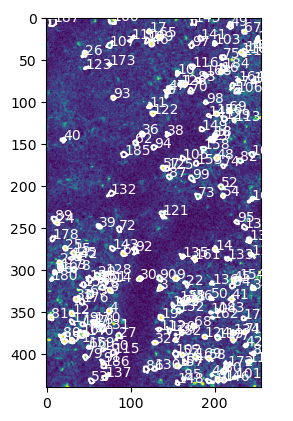

In [5]:
logging.info('Number of components: ' + str(cnm.estimates.A.shape[-1]))
Cn = cm.load(fnames[0], subindices=slice(0,500)).local_correlations(swap_dim=False)
cnm.estimates.plot_contours(img=Cn)

## View components

Now inspect the components extracted by OnACID. Note that if single pass was used then several components would be non-zero only for the part of the time interval indicating that they were detected online by OnACID.

Note that if you get data rate error you can start Jupyter notebooks using:
'jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10'

In [6]:
cnm.estimates.nb_view_components(img=Cn, denoised_color='red');

## Plot timing
The plot below shows the time spent on each part of the algorithm (motion correction, tracking of current components, detect new components, update shapes) for each frame. Note that if you displayed a movie while processing the data (`show_movie=True`) the time required to generate this movie will be included here.

(0.0, 140.0)

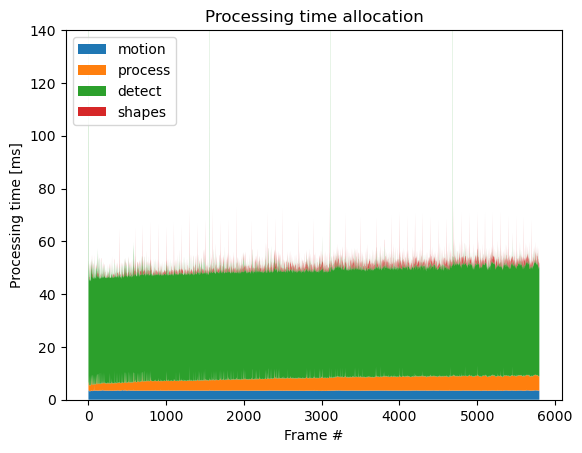

In [7]:
T_motion = 1e3*np.array(cnm.t_motion)
T_detect = 1e3*np.array(cnm.t_detect)
T_shapes = 1e3*np.array(cnm.t_shapes)
T_online = 1e3*np.array(cnm.t_online) - T_motion - T_detect - T_shapes
plt.figure()
plt.stackplot(np.arange(len(T_motion)), T_motion, T_online, T_detect, T_shapes)
plt.legend(labels=['motion', 'process', 'detect', 'shapes'], loc=2)
plt.title('Processing time allocation')
plt.xlabel('Frame #')
plt.ylabel('Processing time [ms]')
plt.ylim([0,140])